In [1]:
%config InlineBackend.figure_format ='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as random
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 14})
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors 
savedir = "/n/holyscratch01/pehlevan_lab/Lab/aatanasov/"
figdir = "figures/"


2022-11-06 20:28:54.919491: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 20:29:05.061291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib/:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64/:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64/:/n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.

In [3]:
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / np.outer(np.linalg.norm(x0, axis=1), np.ones(dim))
  return jnp.array(x)

def pure_target_fn(X, beta, k):
  dim = len(beta)
  z = np.dot(X, beta)
  y = gegenbauer.gegenbauer(z, k+1, dim)[k,:]
  return jnp.array(y)[:, jnp.newaxis]

def generate_train_data(p, beta, k, key):
  emp_dim = 100
  dim = len(beta)
  key, emp_key = random.split(key)
  X = generate_synth_data(p, dim, key)
  y = pure_target_fn(X, beta, k)
  return X, y

def format_ps(pvals):
  result = np.zeros(len(pvals), dtype=int)
  for i, p in enumerate(pvals):
    if p < 10:
      result[i] = p + (p % 2)
    elif p < 300:
      result[i] = p + 10 - (p % 10)
    elif p < 3000:
      result[i] = p + 100 - (p % 100)
    else:
      result[i] = p + 1000 - p % 1000
  return result     

from functools import partial
from jax import jvp, grad, jit
# from jax.tree_util import tree_multimap
# from jax import jvp, grad, jit


# @partial(partial, tree_multimap)
# def norm(x, y):
#   return np.sum((x - y) ** 2)  # actually a _squared_ norm ;)

def param_diff(params0, paramsf):
  return jax.tree_map(lambda x, y: y-x, params0, paramsf)

def jacobian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  return jvp(f0, [params0], [deltaparams])[1]

def hessian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  df0 = lambda params: jvp(f0, [params], [deltaparams])[1]
  return jvp(df0, [params0], [deltaparams])[1]

In [4]:
num_repeats = 20
num_repeats_ker = num_repeats #150
num_repeats_nn = num_repeats #5
num_iter_nn = int(3e4)
min_loss_nn = 1e-6

## NN Hyperparameters
lr = 0.008   # Only being used with adam
layers = 2   # Hidden layers
depth = layers + 1

# For now we are actually not ensembling
ensemble_size_list = [3]

## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 7
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(5000)
p_test = 2000
kmax = 200

num_repeats_eNTK = 3
ensemble_size = 1

# This is the sweep that we are going to be doing:
pvals = np.logspace(logpmin, logpmax, num=num_p).astype('int')
nvals = np.logspace(lognmin, lognmax, num=num_n).astype('int')
pvals = format_ps(pvals)

In [5]:
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / np.outer(np.linalg.norm(x0, axis=1), np.ones(dim))
  return jnp.array(x)

def pure_target_fn(X, beta, k):
  dim = len(beta)
  z = np.dot(X, beta)
  y = gegenbauer.gegenbauer(z, k+1, dim)[k,:]
  return jnp.array(y)[:, jnp.newaxis]

def generate_train_data(p, beta, k, key):
  emp_dim = 100
  dim = len(beta)
  key, emp_key = random.split(key)
  X = generate_synth_data(p, dim, key)
  y = pure_target_fn(X, beta, k)
  return X, y

def format_ps(pvals):
  result = np.zeros(len(pvals), dtype=int)
  for i, p in enumerate(pvals):
    if p < 10:
      result[i] = p + (p % 2)
    elif p < 300:
      result[i] = p + 10 - (p % 10)
    elif p < 3000:
      result[i] = p + 100 - (p % 100)
    else:
      result[i] = p + 1000 - p % 1000
  return result     

from functools import partial
from jax import jvp, grad, jit

def param_dist(params0, paramsf):
  diff = norm(list(params0), list(paramsf))  
  return jnp.sum(jnp.array(jax.tree_util.tree_leaves(diff)))

def param_diff(params0, paramsf):
  return jax.tree_map(lambda x, y: y-x, params0, paramsf)

def jacobian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  return jvp(f0, [params0], [deltaparams])[1]

def hessian_vector(apply_fn, X, params0, deltaparams):
  f0 = lambda params: apply_fn(params, X)
  df0 = lambda params: jvp(f0, [params], [deltaparams])[1]
  return jvp(df0, [params0], [deltaparams])[1]

import neural_tangents as nt
from neural_tangents import stax

# Generate fully connected NN architecture
def fully_connected(num_layers, width, sigma):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = sigma, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std=sigma, b_std=0)] 
  return stax.serial(*layers)

def make_jax(params):
  new_params = []
  for i, layer in enumerate(params):
    new_layer = []
    for wnbs in layer:
      new_wnbs = jnp.array(wnbs)
      new_layer += [new_wnbs]
    new_layer = tuple(new_layer)
    new_params += [new_layer]
  return new_params

In [6]:
num_repeats = 20
num_repeats_ker = num_repeats #150
num_repeats_nn = num_repeats #5
num_iter_nn = int(3e4)
min_loss_nn = 1e-6

## NN Hyperparameters
lr = 0.008   # Only being used with adam
layers = 2   # Hidden layers
depth = layers + 1

# For now we are actually not ensembling
ensemble_size_list = [3]

## Dimension, sample sizes, max eigenvalue mode to generate data
dim = 10
num_p = 15
num_n = 5
logpmin = .5
lognmin = 1.5
logpmax = np.log10(10000-1)
lognmax = np.log10(1000)
p_test = 2000
kmax = 200

num_repeats_eNTK = num_repeats_ker
ensemble_size = 1

# This is the sweep that we are going to be doing:
pvals = np.logspace(logpmin, logpmax, num=num_p).astype('int')
nvals = (np.logspace(lognmin, lognmax, num=num_n).astype('int'))[-1:]
pvals = format_ps(pvals)

In [7]:
k = 3

# Crucially independent test key!! 
test_key = random.PRNGKey(0)
beta_key, const_key, test_key = random.split(test_key, 3)

# Data:
train_sets = []
for d_key in range(20):
  print(f"d = {d_key}", end="\r")
  data_key = random.PRNGKey(d_key)
  train_key = random.split(data_key, len(pvals))
  beta = generate_synth_data(1, dim, beta_key)[0,:]
  y_const = np.sqrt(np.mean((generate_train_data(1000, beta, k, const_key)[1])**2))
  Xs_train = []; ys_train = []
  for i, p in enumerate(pvals):
    X_train, y_train = generate_train_data(p, beta, k, train_key[i])
    y_train = y_train/y_const
    Xs_train += [X_train]
    ys_train += [y_train]
  train_sets += [(Xs_train, ys_train)]

X_test, y_test = generate_train_data(p_test, beta, k, test_key)
y_test = y_test/y_const
test_set = (X_test, y_test)


sigmas = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20]
widths = nvals
numK = 3
numS = len(sigmas)
numN = len(widths)

numP = len(pvals)
numE = 20
numD = 20
P_test = 2000

NTK_errs = np.zeros(shape=(numS, numP, numD)) 
eNTK0_errs = np.zeros(shape=(numS, numN, numP, numE, numD)) 
yhats_eNTK0 = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
NN_errs = np.zeros(shape=(numS, numN, numP, numE, numD))
yhats_NN = np.zeros(shape=(numS, numN, numP, numE, numD, P_test, 1)) 
eNTK0_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))
NN_err_rat = np.zeros(shape=(numS, numN, numP, numE, numD))


for d in range(20):
  print(f"d = {d}")
  for i, sigma in enumerate(sigmas):
    try: NTK_errs[i, :, d] = np.load(savedir+"inf_err_L={}_k={}_s={:.2f}_d={}.npy".format(depth, k, sigma, d))
    except: print(f"NTK error at sigma={sigma} d={d}")
    for j, width in enumerate(widths):    
      try: 
        NN_errs[i, j, :, :, d] = np.load(savedir+"gen_err_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_NN[i, j, :, :, d, :, :] = np.load(savedir+"yhats_NN_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))      
      except: print(f"NN error at width={width}, sigma={sigma} d={d}")
      try: 
        eNTK0_errs[i, j, :, :, d] = np.load(savedir+"gen_err_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
        yhats_eNTK0[i, j, :, :, d, :, :] = np.load(savedir+"yhats_eNTK0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d))
      except: print(f"eNTK0 error at width={width}, sigma={sigma} d={d}")
    

d = 09
d = 1
d = 2
d = 3
d = 4
d = 5
d = 6
d = 7
d = 8
d = 9
d = 10
d = 11
d = 12
d = 13
d = 14
d = 15
d = 16
d = 17
d = 18
d = 19


In [8]:
def zero_to_nan(d):
    array = np.array(d)
    array[array == 0] = np.NaN
    return array

NTK_errs = zero_to_nan(NTK_errs)
eNTK0_errs = zero_to_nan(eNTK0_errs)
NN_errs = zero_to_nan(NN_errs);
yhats_eNTK0 = zero_to_nan(yhats_eNTK0)
yhats_NN = zero_to_nan(yhats_NN);

In [9]:
NN_errs_ens = np.nanmean((np.nanmean(yhats_NN[:, :, :, :, :, :, 0], axis=-3) - y_test[:, 0])**2, axis=-1)
eNTK0_errs_ens = np.nanmean((np.nanmean(yhats_eNTK0[:, :, :, :, :, :, 0], axis=-3) - y_test[:, 0])**2, axis=-1)
NN_err_rat = np.nanmean(NN_errs_ens, axis=-1)/np.nanmean(NN_errs, axis=(-1, -2))
eNTK0_err_rat = np.nanmean(eNTK0_errs_ens, axis=-1)/np.nanmean(eNTK0_errs, axis=(-1, -2))

Text(0, 0.5, '$\\log \\alpha$')

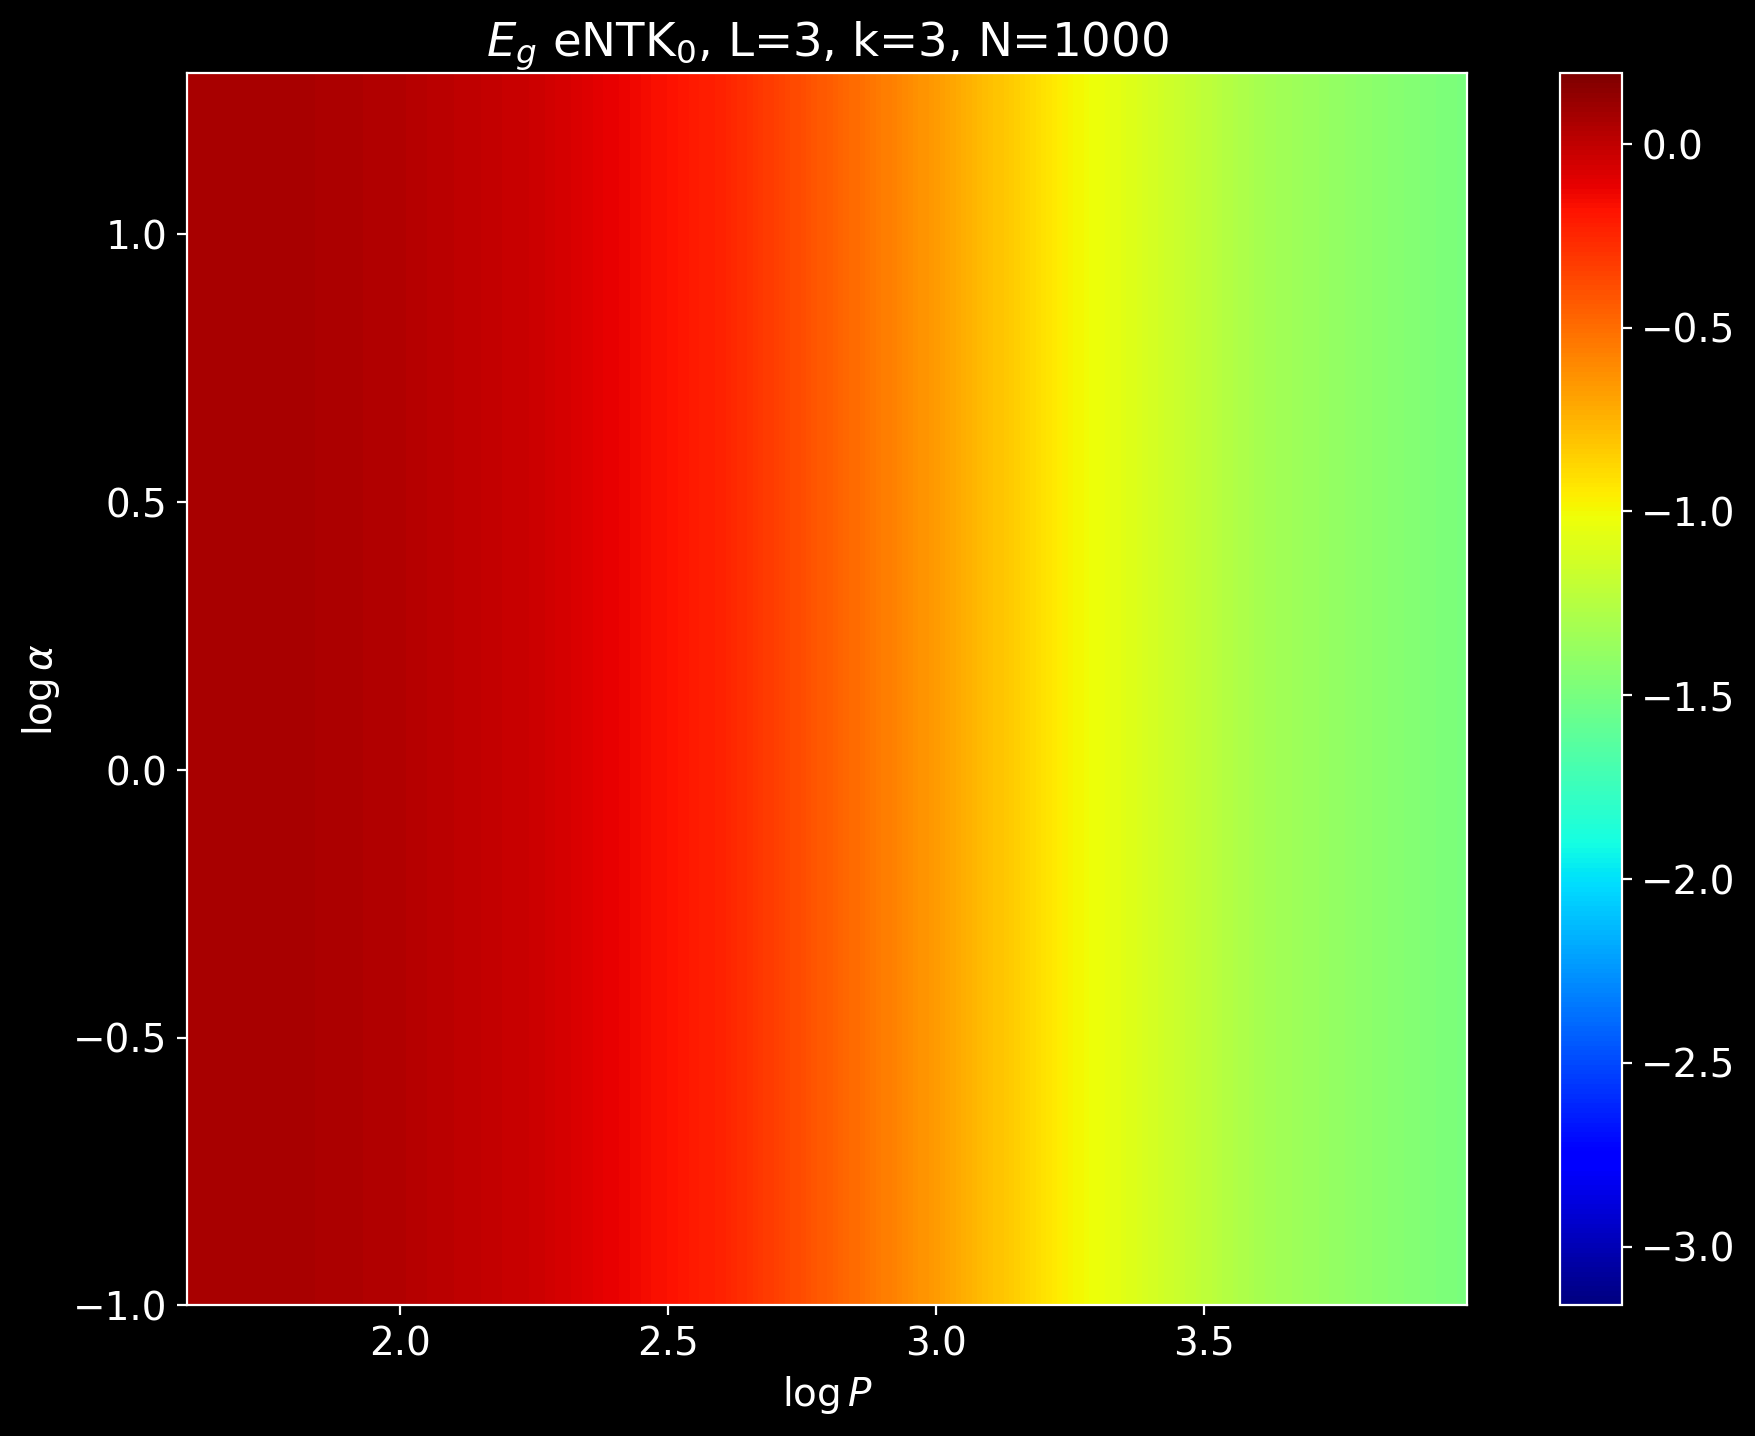

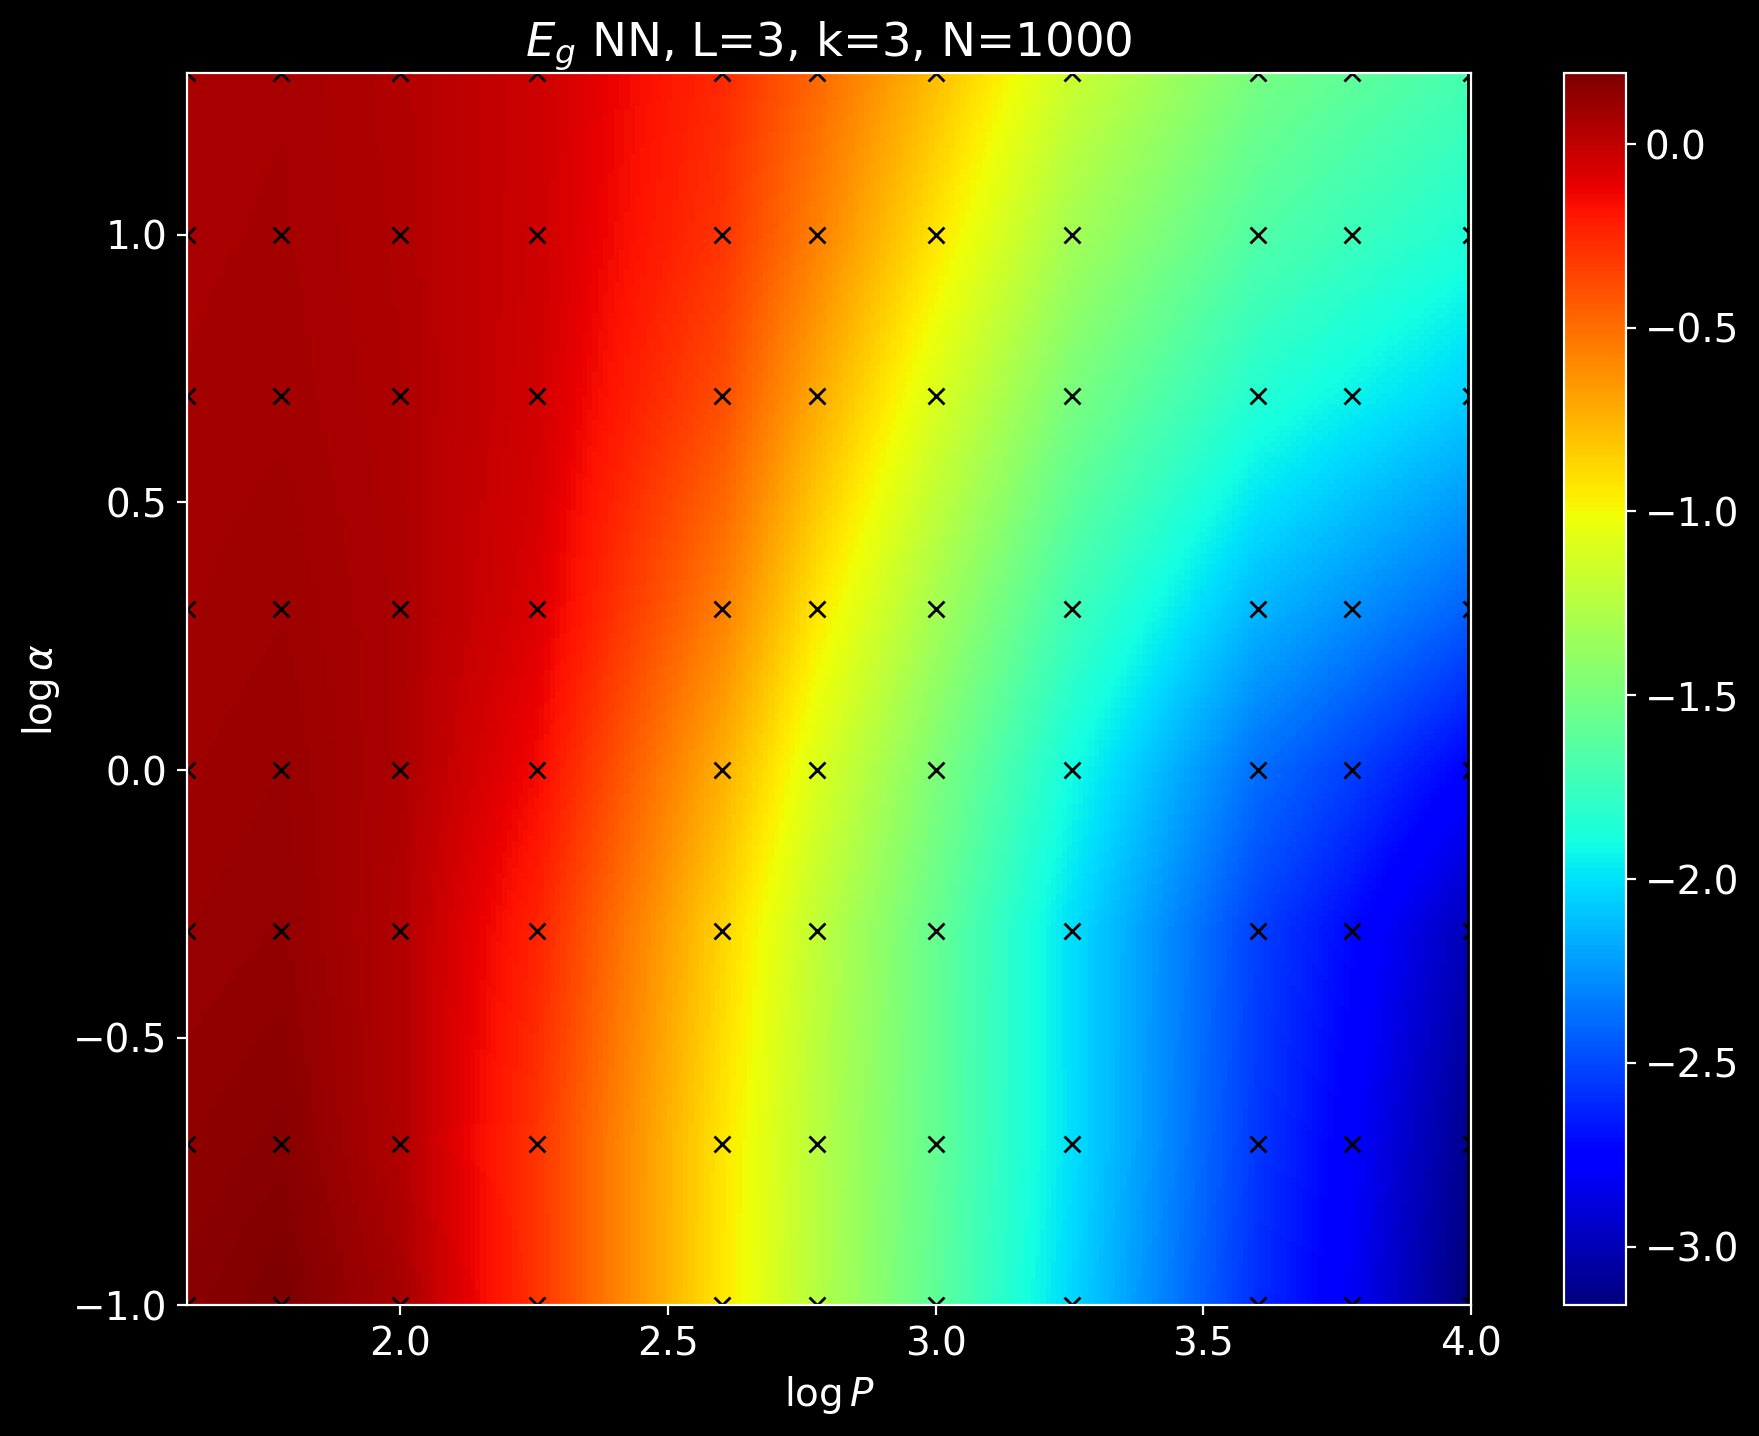

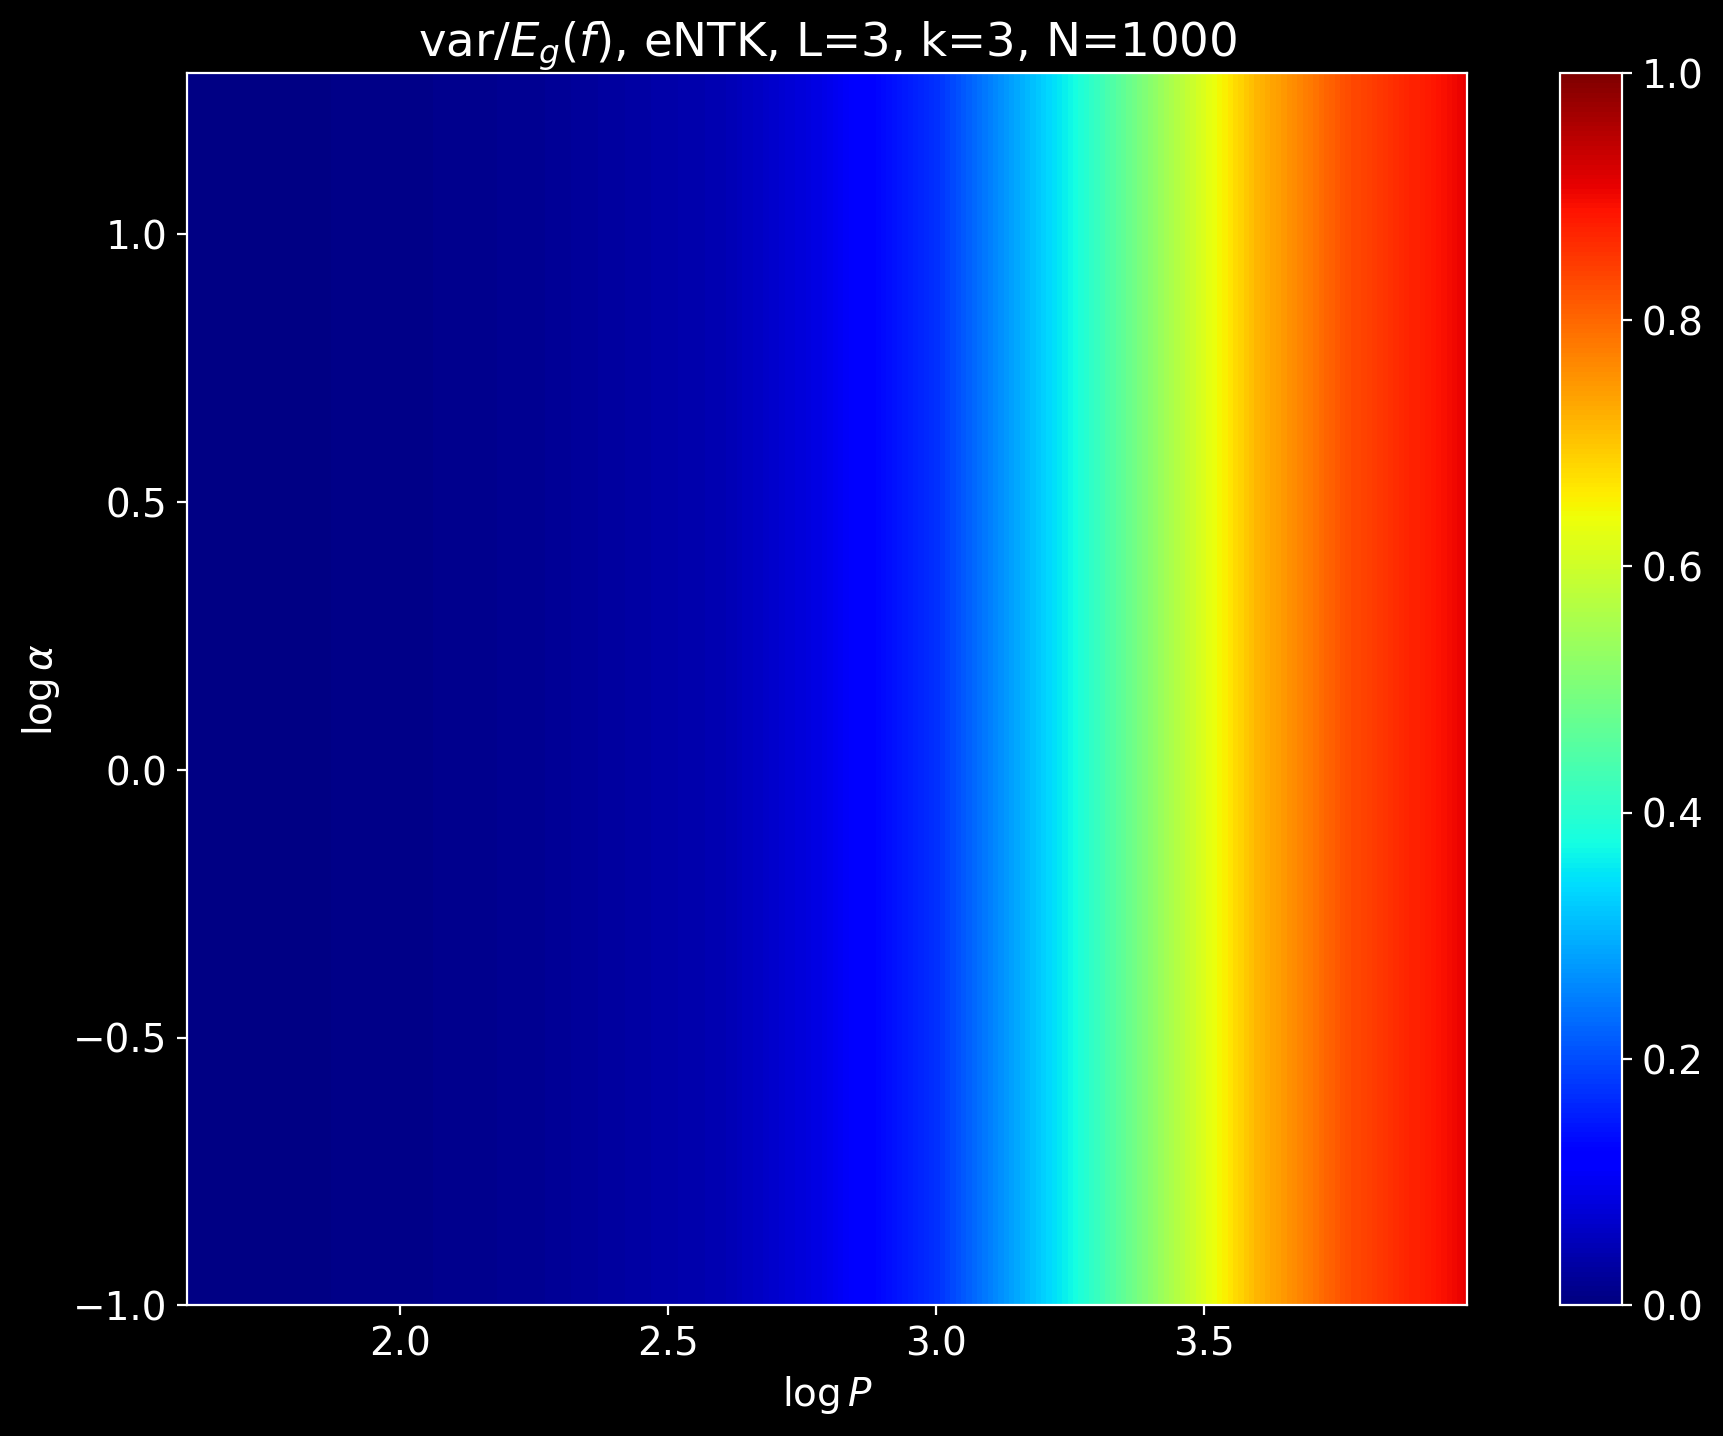

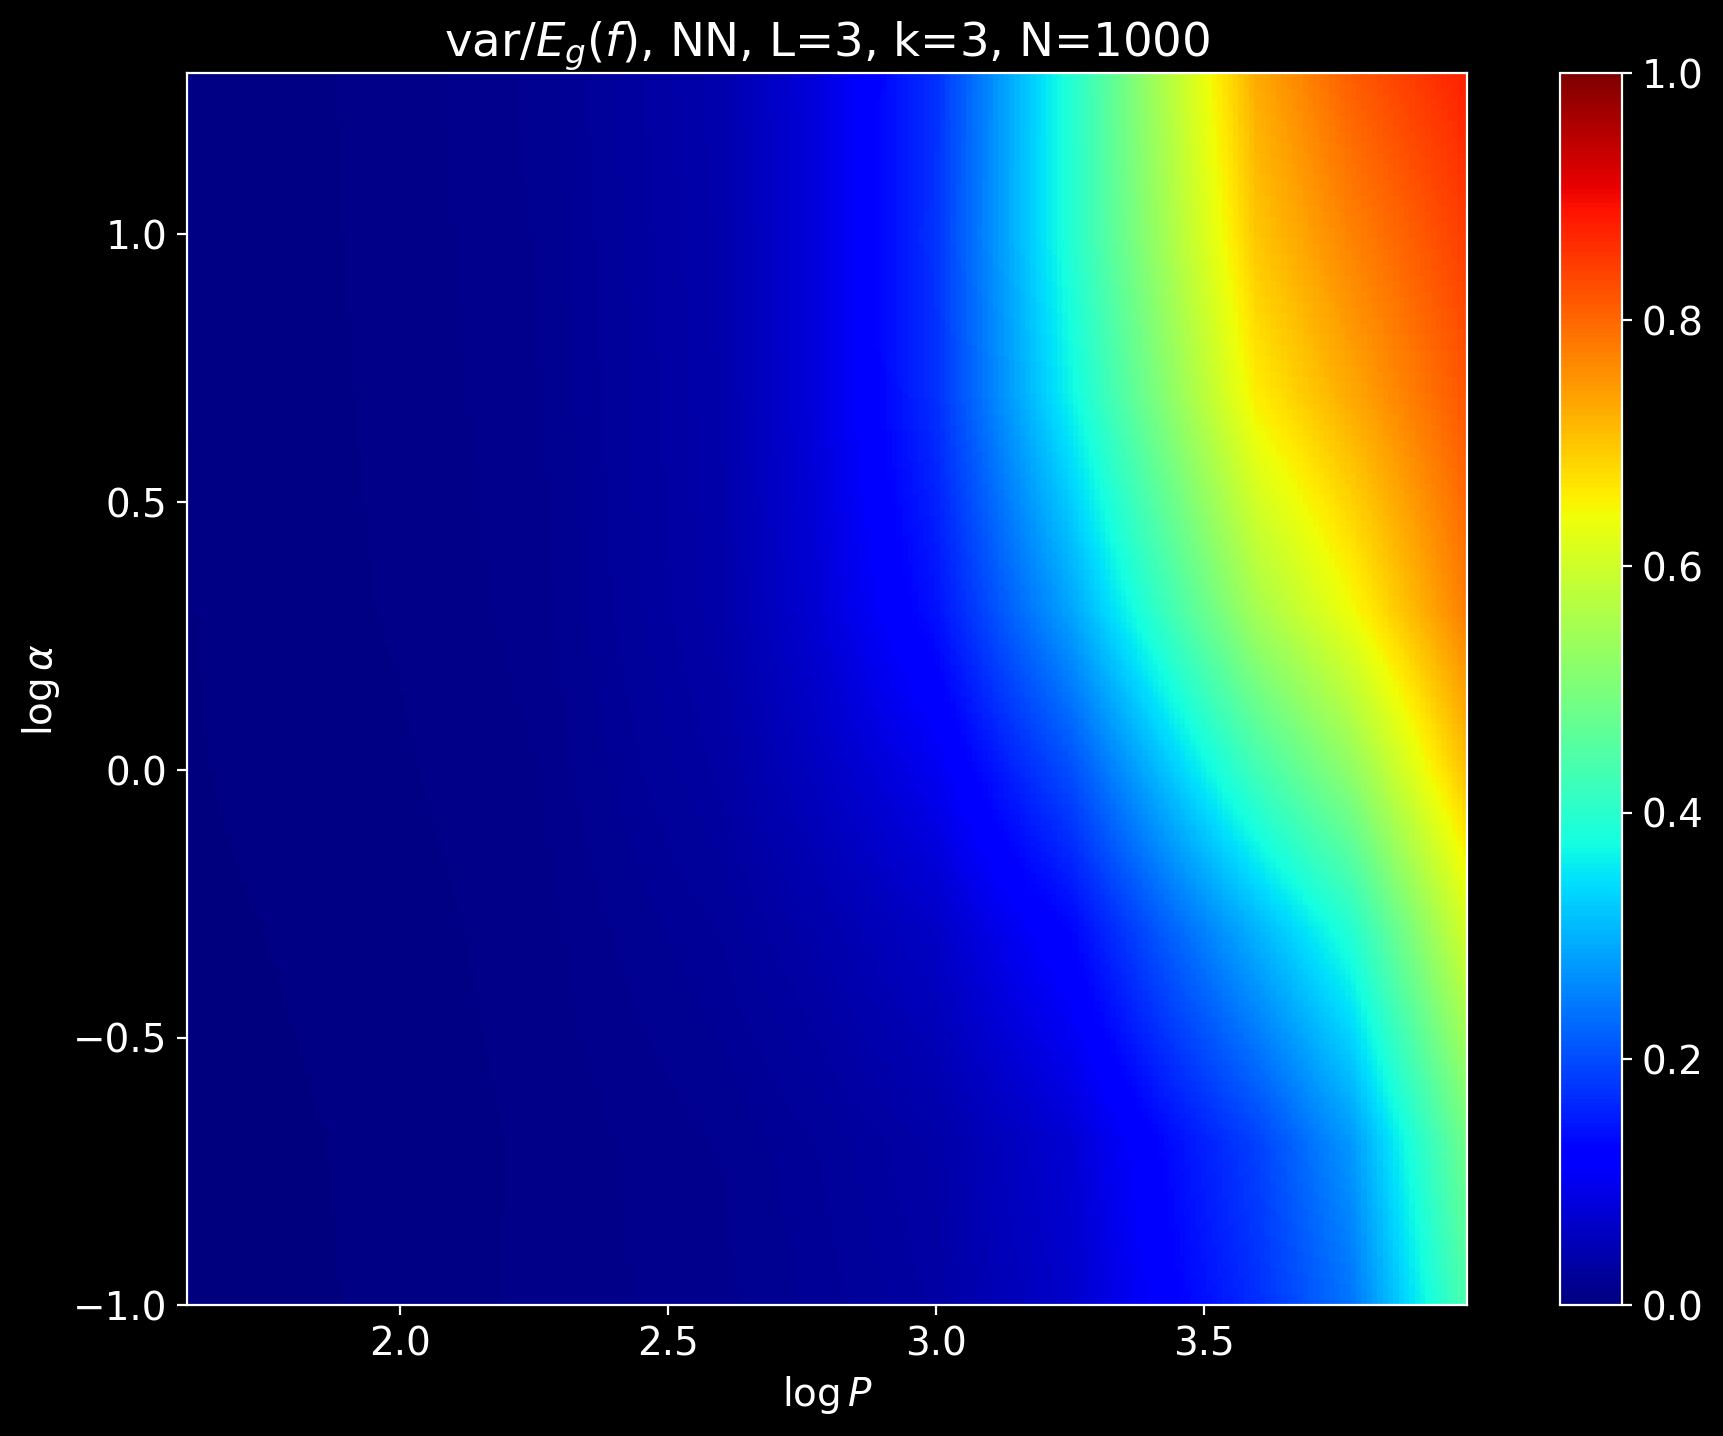

In [10]:
from scipy import interpolate

palette='jet'

nidx = -1
pidx = 4

lpvals = np.log10(pvals[pidx:])
lsigmas = np.log10(sigmas)
lwidths = np.log10(widths)
lNTK_errs = np.log10(np.nanmean(NTK_errs[:, :, :], axis=-1))
leNTK0_errs = np.log10(np.nanmean(eNTK0_errs[:, :, :, :, :], axis=(-2, -1)))
lNN_errs = np.log10(np.nanmean(NN_errs[:, :, :, :, :], axis=(-2, -1)))


x, y = lpvals, lsigmas
xx, yy = np.meshgrid(x, y)

z_eNTK0 = leNTK0_errs[:, nidx, pidx:]
z_NN = lNN_errs[:, nidx, pidx:]
z_eNTK0_err_rat = eNTK0_err_rat[:, nidx, pidx:]
z_NN_err_rat = NN_err_rat[:, nidx, pidx:]

f_eNTK0 = interpolate.interp2d(x, y, z_eNTK0, kind='linear')
f_NN = interpolate.interp2d(x, y, z_NN, kind='linear')

f_eNTK0_rat = interpolate.interp2d(x, y, z_eNTK0_err_rat, kind='linear')
f_NN_rat = interpolate.interp2d(x, y, z_NN_err_rat, kind='linear')


xnew = np.arange(x[0], x[-1], 1e-2)
ynew = np.arange(y[0], y[-1], 1e-2)
int_eNTK0 = f_eNTK0(xnew, ynew)
int_NN = f_NN(xnew, ynew)
int_eNTK0_rat = f_eNTK0_rat(xnew, ynew)
int_NN_rat = f_NN_rat(xnew, ynew)

plt.figure(figsize=(12,8))
plt.imshow(int_eNTK0[::-1], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap=palette)
plt.colorbar()
plt.title(f"$E_g$ eNTK$_0$, L={depth}, k={k}, N={widths[nidx]}")
plt.clim(np.min(int_NN), np.max(int_NN))
plt.xlabel("$\log P$")
plt.ylabel("$\log \\alpha$")


plt.figure(figsize=(12,8))
plt.imshow(int_NN[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap=palette)
plt.colorbar()
plt.title(f"$E_g$ NN, L={depth}, k={k}, N={widths[nidx]}")
plt.plot(xx, yy,'x', c='k')
plt.xlim(np.log10(pvals[pidx]), 4.0)
plt.ylim(-1, np.log10(20))
plt.clim(np.min(int_NN), np.max(int_NN))
plt.xlabel("$\log P$")
plt.ylabel("$\log \\alpha$")


plt.figure(figsize=(12,8))
plt.imshow(1-int_eNTK0_rat[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap=palette)
plt.colorbar()
plt.title(f"var$/E_g(f)$, eNTK, L={depth}, k={k}, N={widths[nidx]}")
plt.xlabel("$\log P$")
plt.clim(0, 1)
plt.ylabel("$\log \\alpha$")


plt.figure(figsize=(12,8))
plt.imshow(1-int_NN_rat[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap=palette)
plt.colorbar()
plt.clim(0, 1)
plt.title(f"var$/E_g(f)$, NN, L={depth}, k={k}, N={widths[nidx]}")
plt.xlabel("$\log P$")
plt.ylabel("$\log \\alpha$")


In [11]:
# from jax.example_libraries.optimizers import l2_norm
from jax.tree_util import tree_map, tree_flatten
def l2_norm(tree):
  """Compute the l2 norm of a pytree of arrays. Useful for weight decay."""
  leaves, _ = tree_flatten(tree)
  return sum(jnp.vdot(x, x) for x in leaves)
sigma = 0.5
k = 3
depth = 3
width = 1000
e = 5
pidx = 14

d = 0
init_fn, apply_fn, kernel_fn = fully_connected(layers, width, np.power(sigma, 1/depth))

# f \cdot y
align = lambda params, X, y:  jnp.dot(y.T,  apply_fn(params, X) )[-1, 0]
# (\nabla_\theta f ) \cdot y
grad_align = grad(align)
# |(\nabla_\theta f ) \cdot y|^2
NTK_align = jit( lambda params, X, y: l2_norm(grad_align(params, X, y)) )
key1, key2 = random.split(random.PRNGKey(0))
num_samples = 250
P_test = 2000

In [19]:
%time paramsfs = jnp.load(savedir + "paramsf_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d), allow_pickle=True)
%time u_tr = jax.random.normal(key1, shape=(pvals[pidx], 1, num_samples))/np.sqrt(num_samples)
%time u_te = jax.random.normal(key2, shape=(P_test, 1, num_samples))/np.sqrt(num_samples)

CPU times: user 3.75 s, sys: 751 ms, total: 4.5 s
Wall time: 3.63 s
CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.57 ms
CPU times: user 1.15 ms, sys: 62 µs, total: 1.22 ms
Wall time: 922 µs


In [98]:
%%timeit
for e in range(5):
    paramsf = make_jax(paramsfs[pidx][e])
    X = X_test
    y = y_test
    trK =  jnp.sum(map_fn(paramsf, X_test, u_te))
    alignment_score(paramsf, X, y, trK)
    # jax.device_get (  NTK_align(paramsf, X, y)/(jnp.dot(y.T, y)[0, 0] * trK) ) 


2.02 s ± 81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
paramsf = make_jax(paramsfs[pidx][e])
align_y = jit(lambda params, X, y: NTK_align(params, X, y))
map_fn = jit(vmap(align_y, in_axes=(None, None, -1)))
alignment_score = jit(lambda params, X, y, K: NTK_align(params, X, y)/(jnp.dot(y.T, y) * K))

In [62]:
%%time
trK =  jnp.sum(map_fn(paramsf, X_test, u_te))
#ans = jax.device_get (  NTK_align(paramsf, X, y)/(jnp.dot(y.T, y)[0, 0] * trK) ) 
#print(ans)


CPU times: user 815 µs, sys: 0 ns, total: 815 µs
Wall time: 574 µs


In [13]:
l2_norm([1,2,3])

DeviceArray(14, dtype=int32, weak_type=True)

In [48]:
from functools import partial
import numpy as np
from jax import pmap
from jax.tree_util import tree_map, tree_flatten

width = 1000


numP = 15
numS = 8
numD = 5
numE = 5
align_tr0_s02 = np.zeros((numS, numP, numD, numE))
align_te0_s02 = np.zeros((numS, numP, numD, numE))
align_trf_s02 = np.zeros((numS, numP, numD, numE))
align_tef_s02 = np.zeros((numS, numP, numD, numE))


key1, key2 = random.split(random.PRNGKey(0))
num_samples = 50
P_test = 2000
num_test = 100

X_test = test_set[0]
y_test = test_set[1]

align_y = jit(lambda params, X, y: NTK_align(params, X, y))
map_fn = jit(vmap(align_y, in_axes=(None, None, -1)))
alignment_score = jit(lambda params, X, y, K: NTK_align(params, X, y)/(jnp.dot(y.T, y)[0, 0] * K))

for i, sigma in enumerate(sigmas):
  if i < 6: continue
  # for j, width in enumerate(widths):
  j = len(widths) - 1
  init_fn, apply_fn, kernel_fn = fully_connected(layers, width, np.power(sigma, 1/depth))
  apply_fn = jit(apply_fn)
  align = lambda params, X, y:  jnp.dot(y.T,  apply_fn(params, X) )[-1, 0]
  grad_align = grad(align)
  NTK_align = jit( lambda params, X, y: l2_norm(grad_align(params, X, y)) )
  for d in range(numD):
    print(f"s = {sigma}, N={width}, d = {d}")
    try:
      params0s = jnp.load(savedir + "params_0_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d), allow_pickle=True)
      paramsfs = jnp.load(savedir + "params_f_N={}_L={}_k={}_s={:.2f}_d={}.npy".format(width, depth, k, sigma, d), allow_pickle=True)
    except:
      print(f"Error at N={width}, s={sigma}, d = {d}")
      continue
    for pidx in range(numP):
      print(f"\rpidx = {pidx+1} / {numP}", end="")
      u_tr = jax.random.normal(key1, shape=(pvals[pidx], 1, num_samples))/np.sqrt(num_samples)
      u_te = jax.random.normal(key2, shape=(num_test, 1, num_samples))/np.sqrt(num_samples)
      for e in range(numE):
        params0 = make_jax(params0s[pidx][e])
        paramsf = make_jax(paramsfs[pidx][e])
        # X = train_sets[d][0][pidx]
        # y = train_sets[d][1][pidx]
        # trK = jnp.sum(vmap(lambda y: NTK_align(params0, X, y), in_axes=-1)(u_tr))
        # align_tr0_s02[pidx, d, e] = jax.device_get ( NTK_align(params0, X, y)/(np.dot(y.T, y)[0, 0] * trK) ) 
        X = X_test[:num_test]
        y = y_test[:num_test]
        # trK = jnp.sum(vmap(lambda y: NTK_align(params0, X, y), in_axes=-1)(u_te))
        trK = jnp.sum(map_fn(params0, X, u_te))
        align_te0_s02[i, pidx, d, e] = jax.device_get (  alignment_score(params0, X, y, trK) ) 
        
        # X = train_sets[d][0][pidx]
        # y = train_sets[d][1][pidx]
        # trK = jnp.sum(vmap(lambda y: NTK_align(paramsf, X, y), in_axes=-1)(u_tr))
        # align_trf_s02[pidx, d, e] = jax.device_get ( NTK_align(paramsf, X, y)/(np.dot(y.T, y)[0, 0] * trK) ) 
        X = X_test[:num_test]
        y = y_test[:num_test]
        #trK = jnp.sum(vmap(lambda y: NTK_align(paramsf, X, y), in_axes=-1)(u_te))
        trK = jnp.sum(map_fn(paramsf, X, u_te))
        align_tef_s02[i, pidx, d, e] = jax.device_get ( alignment_score(paramsf, X, y, trK) ) 
    print()

np.save(savedir+"align_tr0_02", align_tr0_s02)
np.save(savedir+"align_te0_02", align_te0_s02)

s = 10.0, N=1000, d = 0
pidx = 15 / 15
s = 10.0, N=1000, d = 1
pidx = 15 / 15
s = 10.0, N=1000, d = 2
pidx = 15 / 15
s = 10.0, N=1000, d = 3
pidx = 15 / 15
s = 10.0, N=1000, d = 4
pidx = 15 / 15
s = 20, N=1000, d = 0
pidx = 15 / 15
s = 20, N=1000, d = 1
pidx = 15 / 15
s = 20, N=1000, d = 2
pidx = 15 / 15
s = 20, N=1000, d = 3
pidx = 15 / 15
s = 20, N=1000, d = 4
pidx = 15 / 15


In [45]:
import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style("darkgrid")
sns.set_palette("seismic")

In [52]:
align_tef_s10 = np.mean(align_tef_s02, axis=(-2, -1))[-2:, :]
align_te0_s10 = np.mean(align_te0_s02, axis=(-2, -1))[-2:, :]

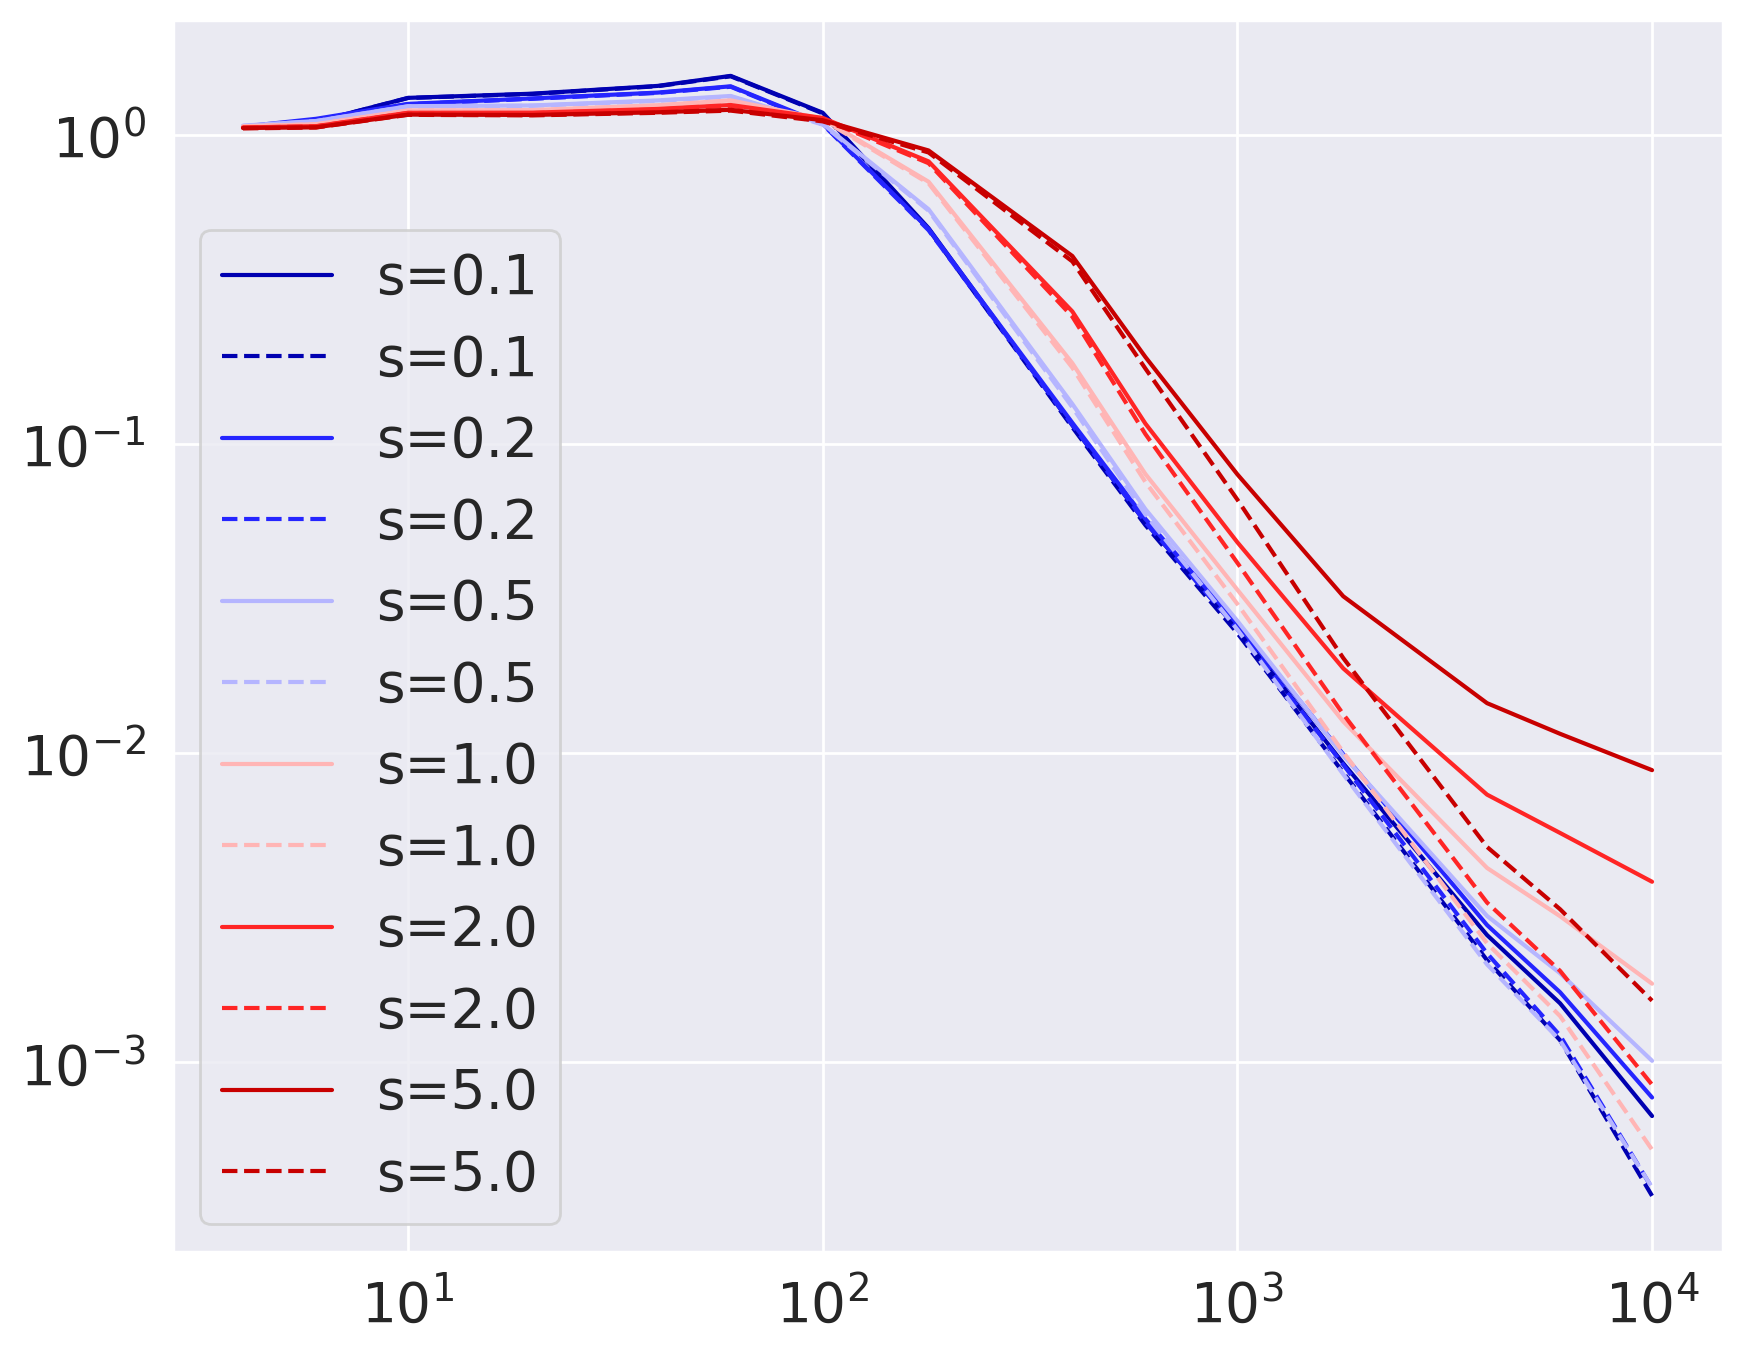

In [25]:
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.loglog(pvals, np.nanmean(NN_errs[i, -1, :], axis=(-2, -1)), label=f"s={sigmas[i]}", c=f"C0{i}")
    plt.loglog(pvals, np.nanmean(NN_errs_ens[i, -1, :], axis=(-1)), '--', label=f"s={sigmas[i]}", c=f"C0{i}")
plt.legend()
plt.show()

# for i in range(6):
#     plt.plot(pvals, NN_errs_ens[i, -1, :, 0], label=f"s={sigmas[i]}")

In [33]:
align_tef_s02.shape

(6, 15, 5, 5)

In [87]:
temp = align_tef_s02.copy()

In [89]:
np.save(savedir+"align_tr0_02", align_tr0_s02)
np.save(savedir+"align_te0_02", align_te0_s02)
np.save(savedir+"align_trf_02", align_trf_s02)
np.save(savedir+"align_tef_02", align_tef_s02)

In [84]:
align_tef_s02 = np.load(savedir+"align_tef_02.npy")

In [65]:
np.save(savedir+"align_tr0", align_tr0)
np.save(savedir+"align_te0", align_te0)
np.save(savedir+"align_trf", align_trf)
np.save(savedir+"align_tef", align_tef)

NameError: name 'align_tr0' is not defined

In [ ]:
get_alignf = np.load(savedir+"align_tef.npy")


In [ ]:
np.save(savedir+"align_tr0", align_tr0)
np.save(savedir+"align_te0", align_te0)
np.save(savedir+"align_trf", align_tr)
np.save(savedir+"align_tef", align_te)

In [90]:
align_tr0 = np.load(savedir+"align_tr0.npy")
align_te0 = np.load(savedir+"align_te0.npy")
align_trf = np.load(savedir+"align_trf.npy")
align_tef = np.load(savedir+"align_tef.npy")

Text(0.5, 1.0, 'Align$_f$/Align$_i$, N=1000, k=3, L=3, $\\alpha$=0.1')

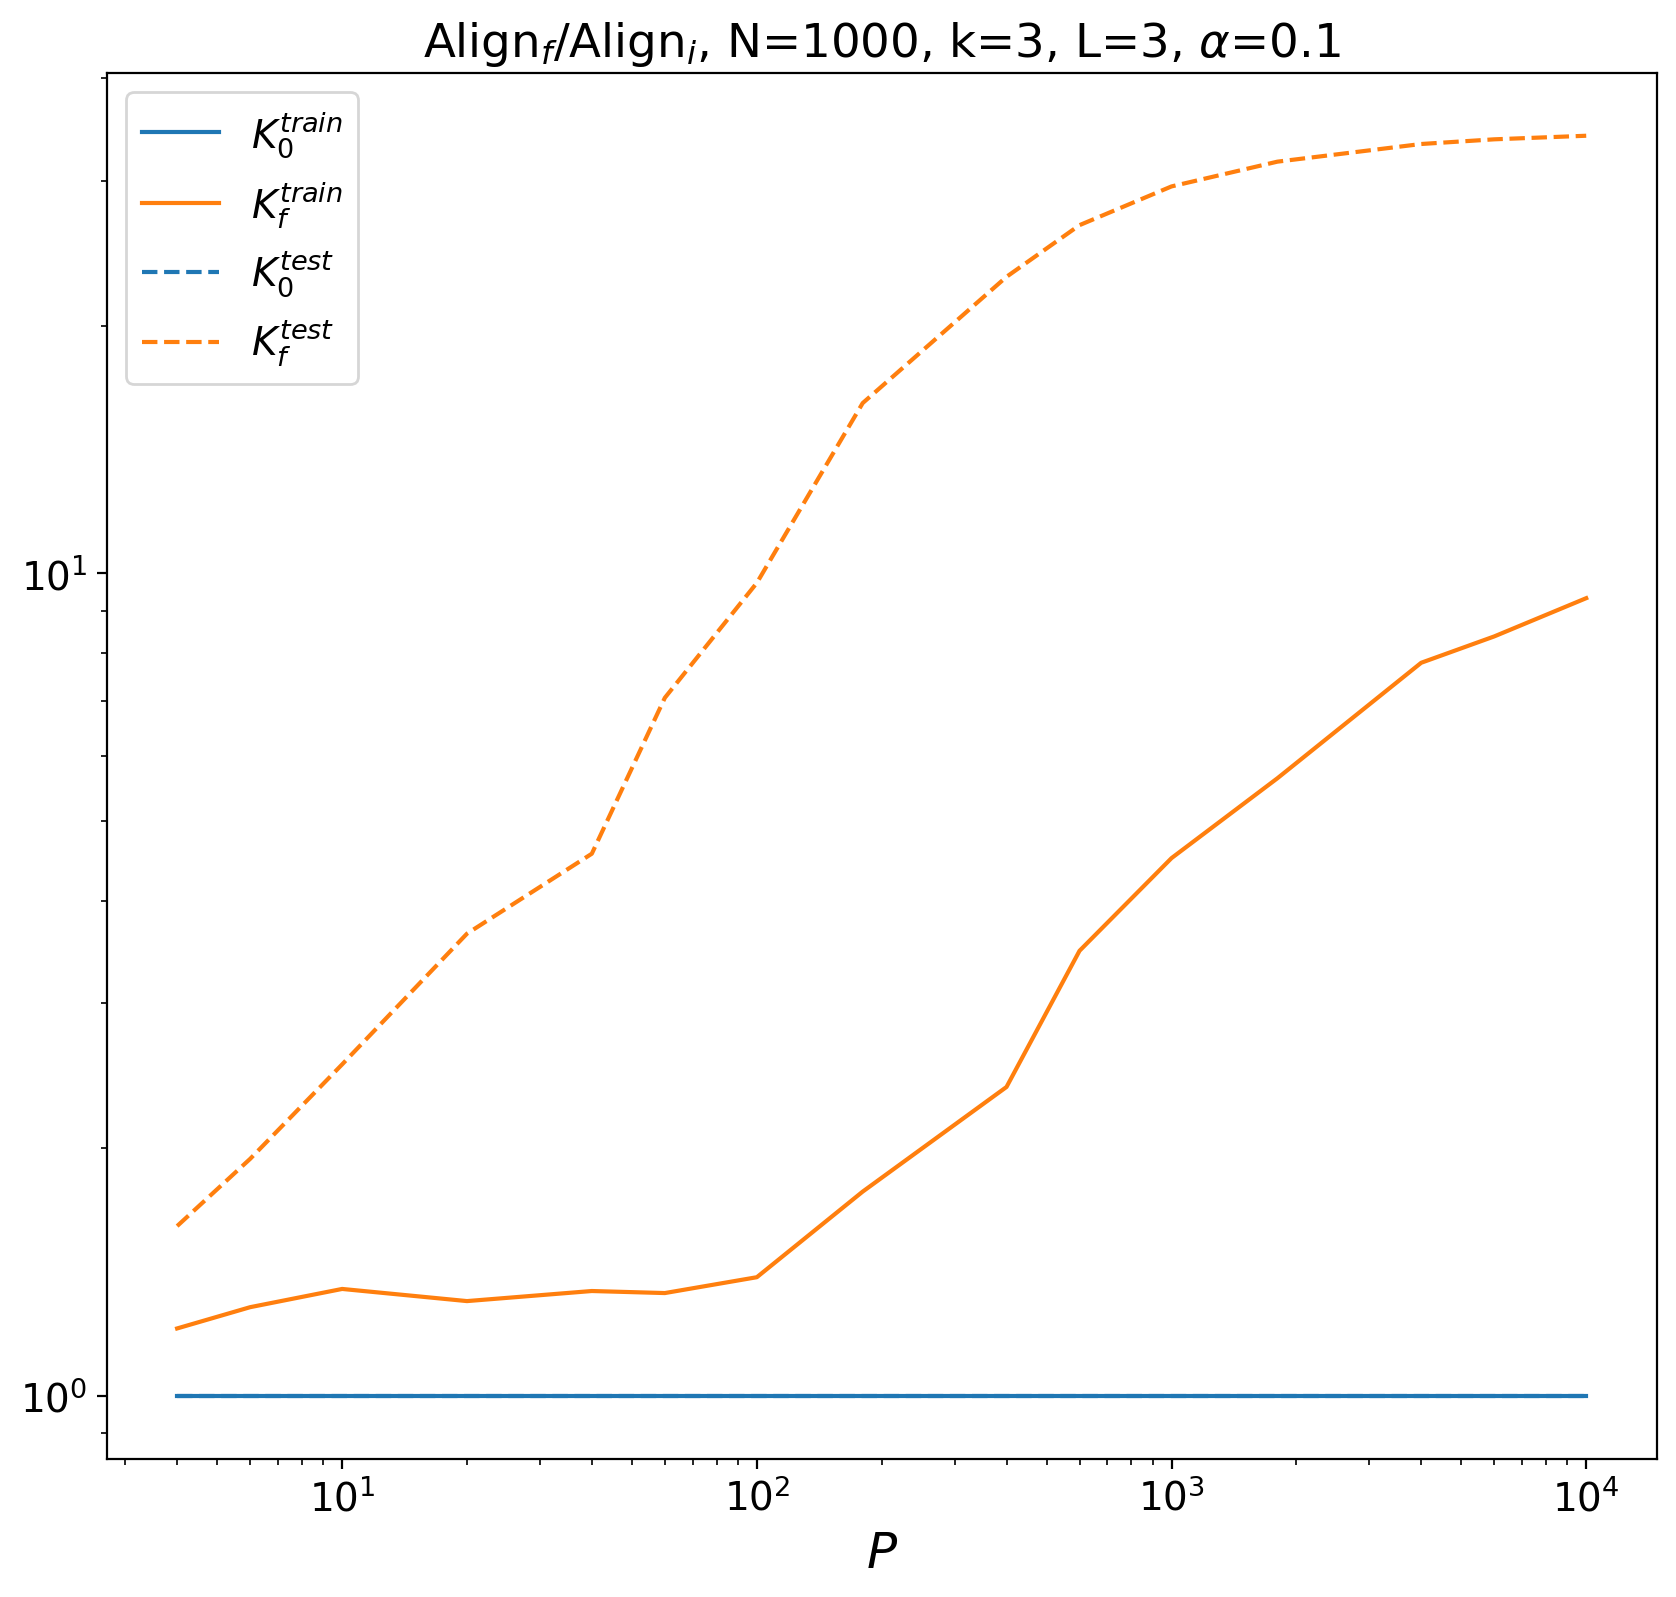

In [68]:
plt.figure(figsize=(10, 9))
plt.loglog(pvals, np.nanmean(align_tr0[0, :, :], axis=-1)/np.nanmean(align_tr0[0, :, :], axis=-1), label="$K_0^{train}$")
plt.loglog(pvals, np.nanmean(align_trf[0, :, :], axis=-1)/np.nanmean(align_tr0[0, :, :], axis=-1), label="$K_f^{train}$")
plt.loglog(pvals, np.nanmean(align_te0[0, :, :], axis=-1)/np.nanmean(align_te0[0, :, :], axis=-1), 'C0--', label="$K_0^{test}$")
plt.loglog(pvals, np.nanmean(align_tef[0, :, :], axis=-1)/np.nanmean(align_te0[0, :, :], axis=-1), 'C1--', label="$K_f^{test}$")
plt.legend(loc=2)
plt.xlabel("$P$", fontsize=18)
plt.title(f"Align$_f$/Align$_i$, N={width}, k={k}, L={depth}, $\\alpha$={sigmas[0]}")

In [53]:
align_tef.shape, np.nanmean(align_tef_s02, axis=(-1, -2)).shape

((5, 15, 20), (15,))

In [54]:
np.insert(np.nanmean(align_tef,axis=-1), 1, np.nanmean(align_tef_s02, axis=(-1, -2)), axis=0)

array([[0.00502814, 0.00606937, 0.00790683, 0.01140077, 0.01426007,
        0.02206269, 0.03043488, 0.05034837, 0.07169513, 0.08285424,
        0.09233926, 0.09896595, 0.10398184, 0.1053535 , 0.10641398],
       [0.0019258 , 0.0019193 , 0.00195724, 0.00203311, 0.00201223,
        0.00224282, 0.00244894, 0.00363815, 0.00550868, 0.00657919,
        0.00729385, 0.00786454, 0.00841366, 0.00856986, 0.00873413],
       [0.0033658 , 0.00355067, 0.00396318, 0.00477839, 0.00558969,
        0.00750602, 0.00976551, 0.01495061, 0.02173787, 0.02598047,
        0.02978409, 0.0325976 , 0.0345637 , 0.03500871, 0.03537128],
       [0.00319449, 0.00326252, 0.00343163, 0.00378532, 0.00418333,
        0.00516013, 0.0063269 , 0.00906606, 0.01298682, 0.01548574,
        0.01788776, 0.0197922 , 0.02110091, 0.02144861, 0.02163904],
       [0.00312848, 0.00312844, 0.00313273, 0.00313556, 0.00314437,
        0.0031727 , 0.0032136 , 0.00332905, 0.00365043, 0.00389683,
        0.00413792, 0.00436014, 0.00453498, 

In [57]:
np.insert(np.nanmean(align_tef,axis=-1), 1, np.nanmean(align_tef_s02, axis=(-1, -2)), axis=0).shape

(6, 15)

In [ ]:
te_f

NameError: name 'align_tef' is not defined

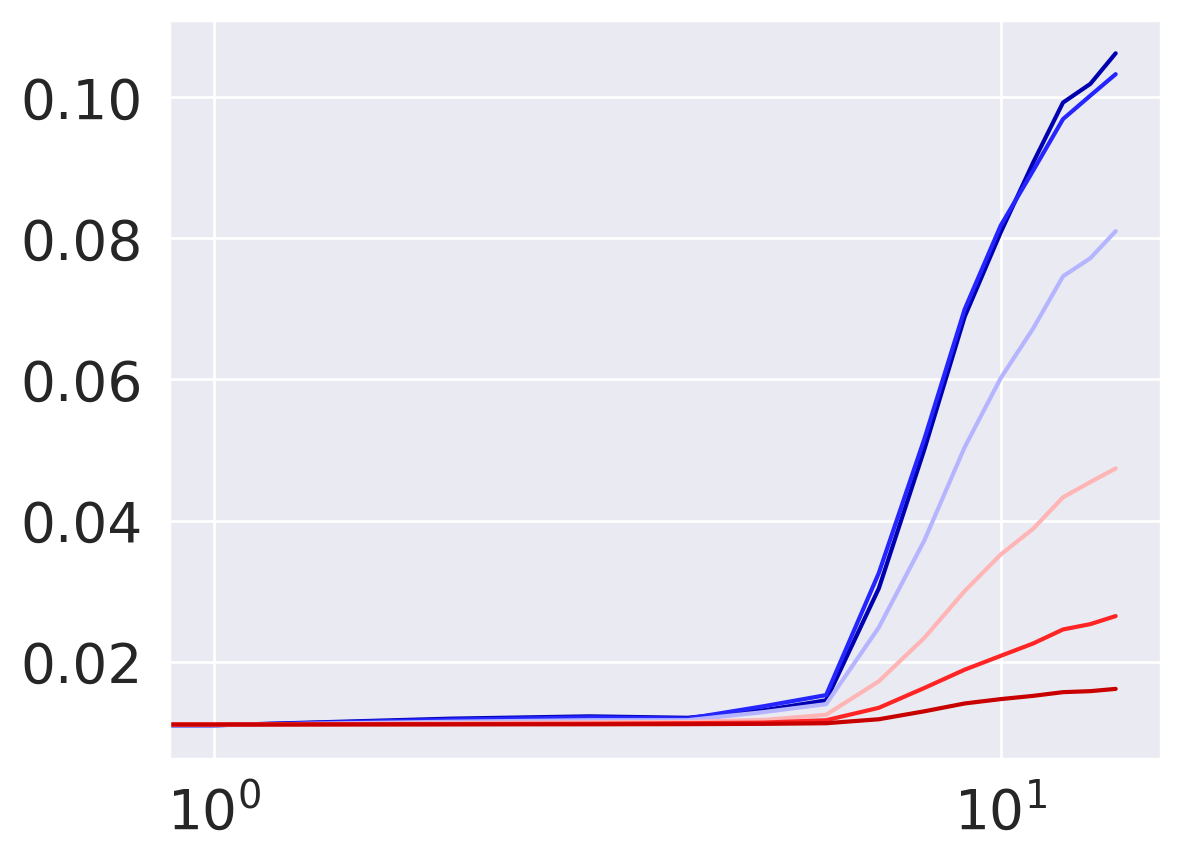

In [47]:
aligns = np.nanmean(align_tef_s02,axis = (-1, -2))

# plt.plot(align_tef[0, :, 0])
for i in range(len(sigmas[:6])):
    plt.semilogx(aligns[i, :])
#plt.plot(align_tef[1, :, 0]) 
# plt.plot(align_tef[2, :, 0])
for i in range(len(sigmas[:6])-1):
    if i == 1:
        plt.semilogx(np.nanmean(align_tef[i, :], axis=-1), '--')
    plt.semilogx(np.nanmean(align_tef[i, :], axis=-1), '--')

IndexError: index 6 is out of bounds for axis 0 with size 6

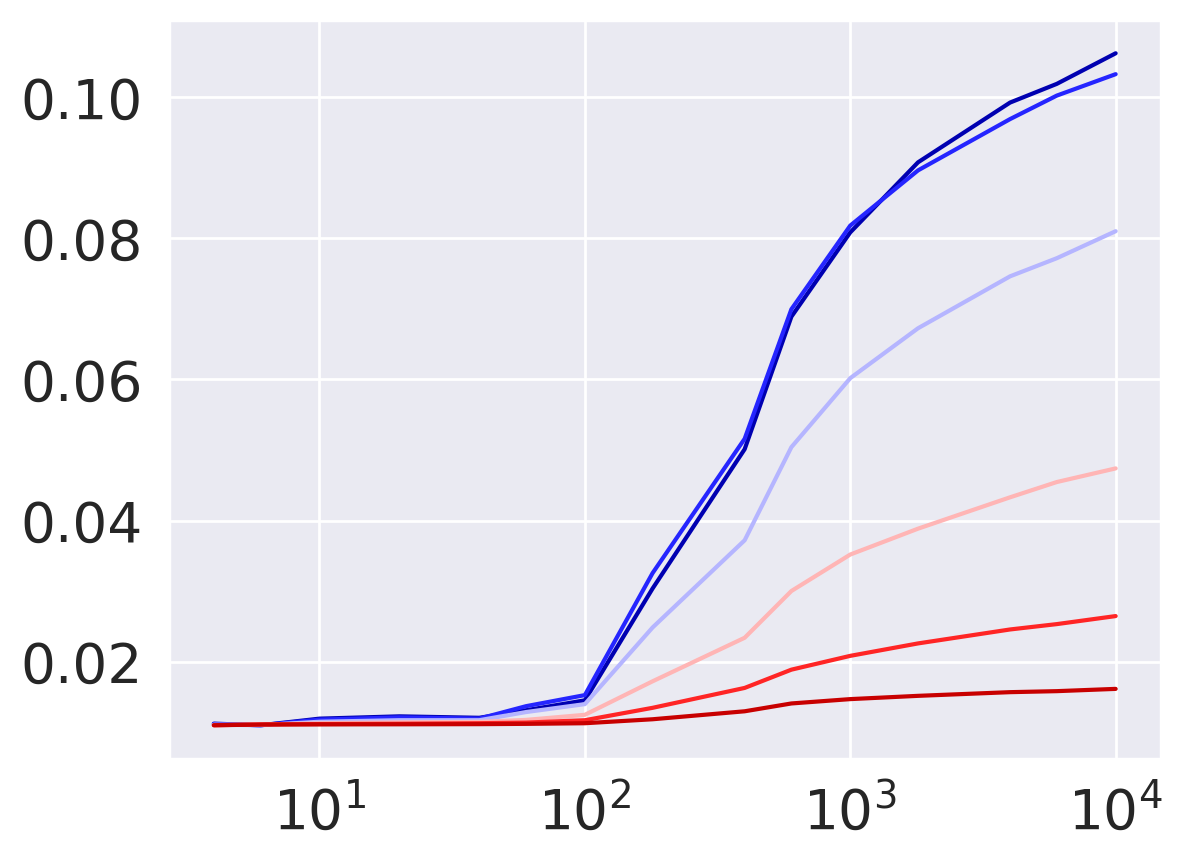

In [30]:
for i in range(len(sigmas)):
    plt.semilogx(pvals, np.nanmean(align_tef_s02[i, :, :], axis=(-1, -2)), label=f"$\\alpha$={sigmas[i]}")
# plt.plot(pvals, np.nanmean(5*align_tef_s02, axis=(-1, -2)), label=f"$\\alpha$={sigmas[-1]}")
plt.legend()

In [62]:
sns.reset_orig()
# aligns = np.mean(align_te_f, axis=(-2, -1))

In [59]:
aligns2 = np.concatenate((aligns, align_tef_s10), axis=0)

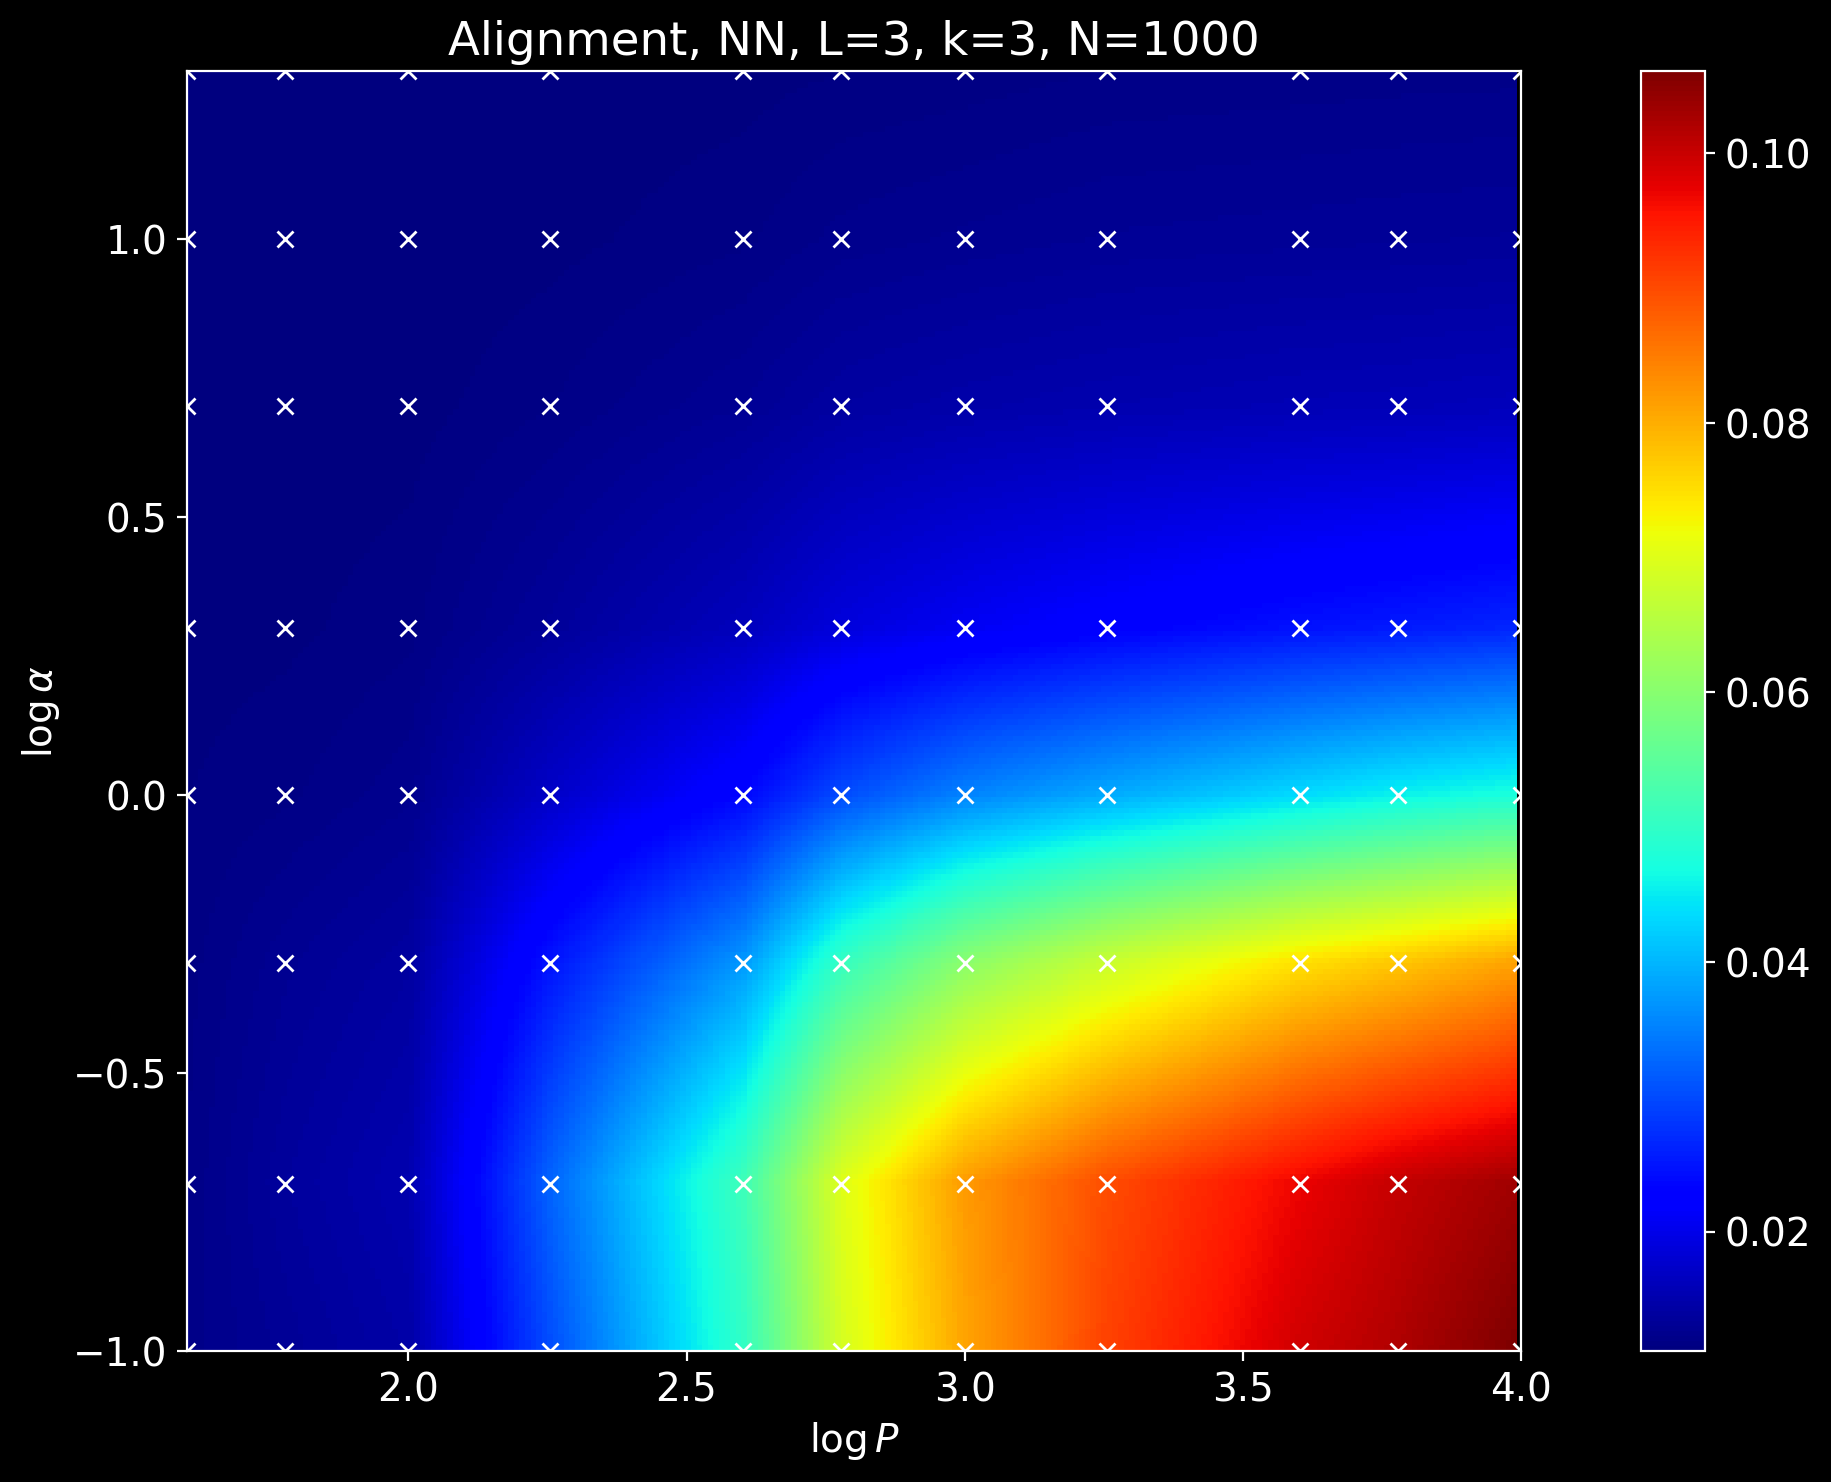

In [66]:
from scipy import interpolate

palette='jet'

nidx = -1
pidx = 4

lwidths = np.log10(widths)
# align_tr = zero_to_nan(align_tr)
align_te = aligns2 # # zero_to_nan(align_te)

lpvals = np.log10(pvals[4:])
lsigmas = np.log10(sigmas)

plt.figure(figsize=(12, 8))
nidx = -1
x, y = lpvals, lsigmas
xx, yy = np.meshgrid(x, y)

z_align = align_te[:, 4:]
f_align = interpolate.interp2d(x, y, z_align, kind='linear')

xnew = np.arange(x[0], x[-1], 1e-2)
ynew = np.arange(y[0], y[-1], 1e-2)
int_align = f_align(xnew, ynew)

# plt.subplot(1,3,3)
plt.imshow(int_align[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap='jet')
plt.colorbar()
# plt.clim(0, 1)
plt.plot(xx, yy,'x', c='w')
plt.xlim(np.log10(pvals[pidx]), 4.0)
plt.ylim(-1, np.log10(20))
plt.title(f"Alignment, NN, L={depth}, k={k}, N={widths[nidx]}")
plt.xlabel("$\log P$")
plt.ylabel("$\log \\alpha$")
plt.subplots_adjust(left=0.0,
                    bottom=0.1, 
                    right=1.0, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1.0)



# plt.plot(aligns_tr)
# plt.plot(aligns_te)

NameError: name 'align_te' is not defined

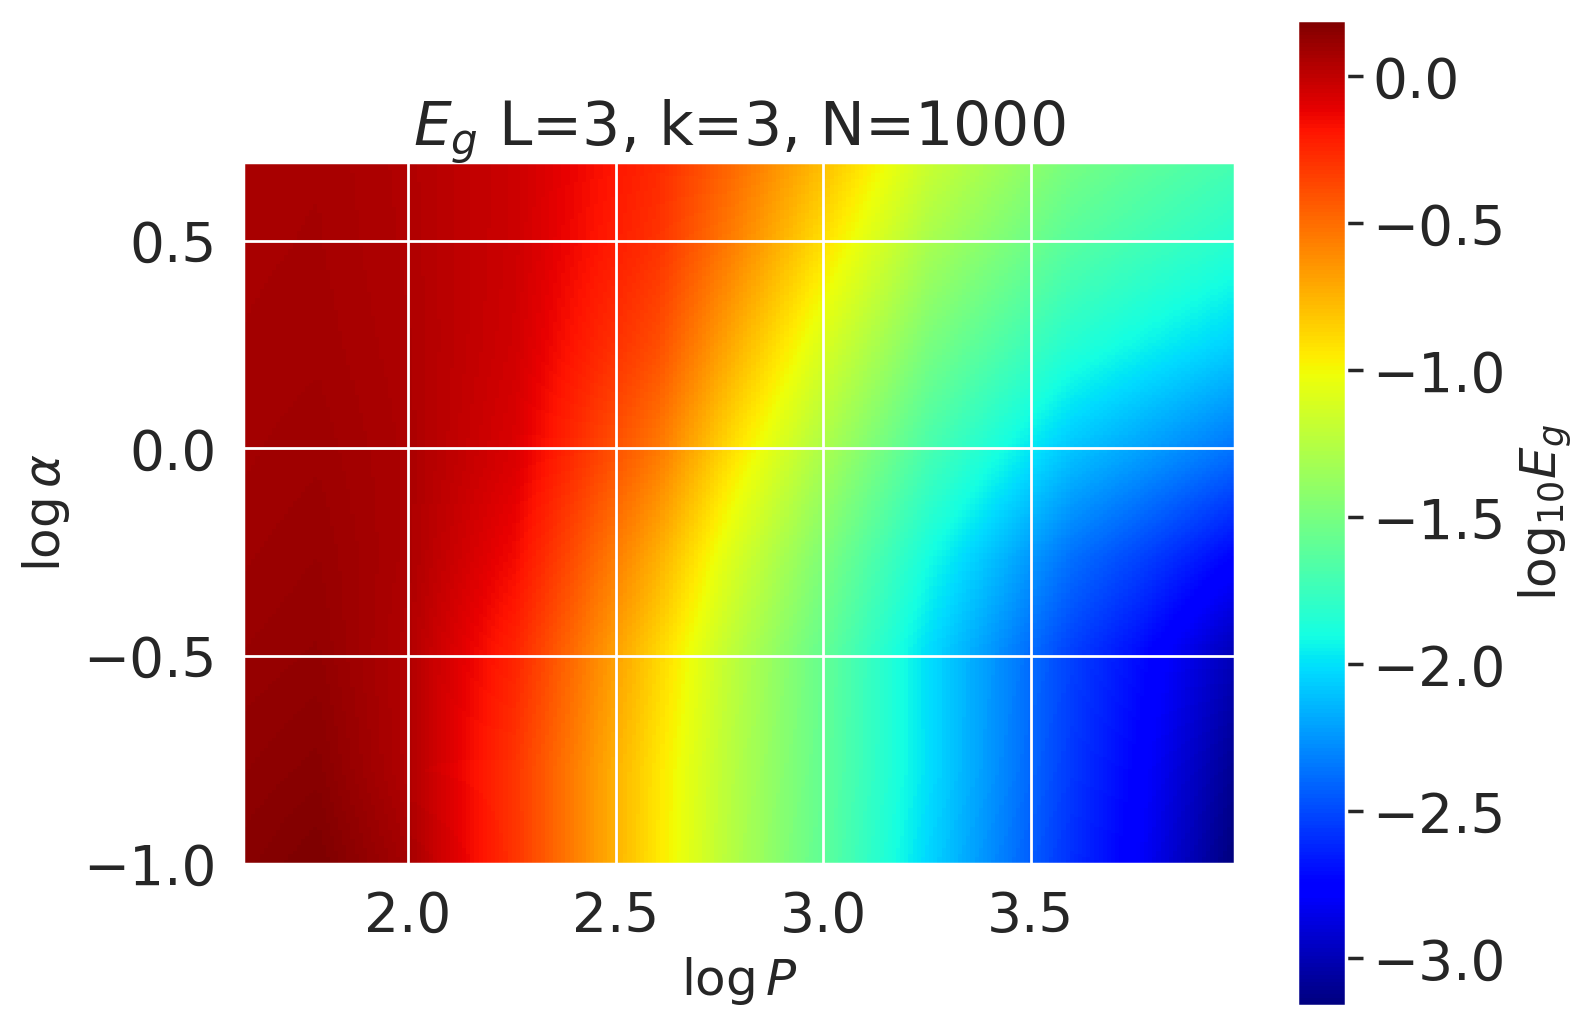

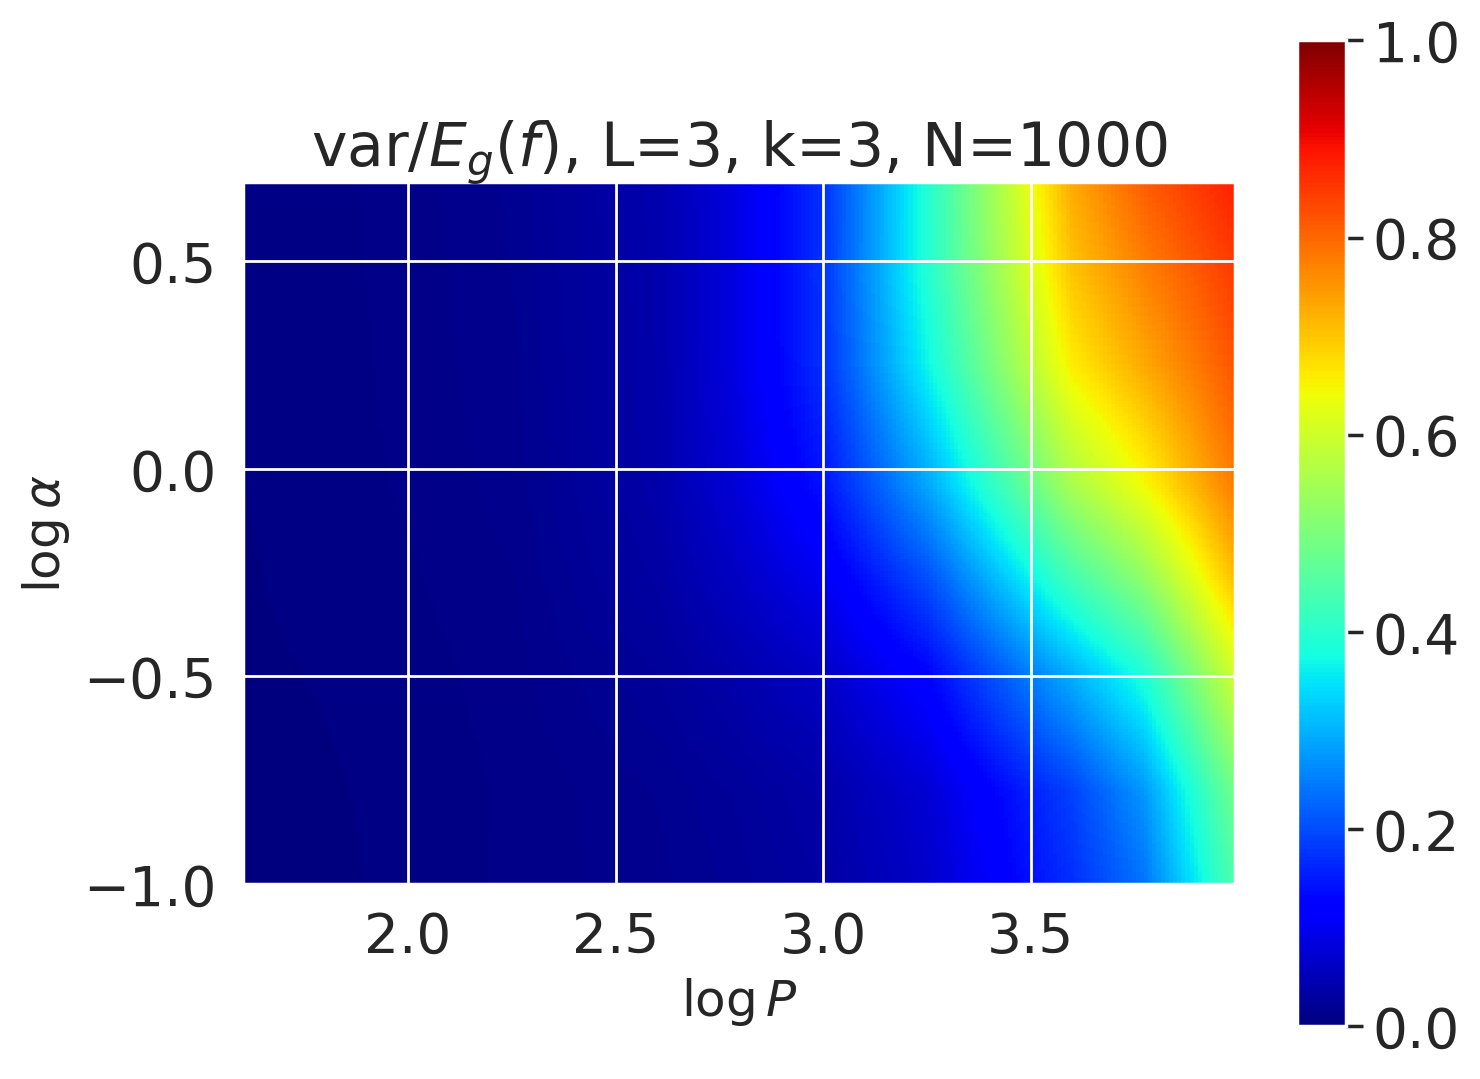

In [32]:
nidx = -1
x, y = lpvals, lsigmas
xx, yy = np.meshgrid(x, y)


xnew = np.arange(x[0], x[-1], 1e-2)
ynew = np.arange(y[0], y[-1], 1e-2)

fig = plt.figure(figsize=(8,8))
# ax = plt.axes()
# im = ax.imshow(np.arange(100).reshape((10,10)))

# plt.subplot(1,3,1)
plt.imshow(int_NN[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap='jet')
cbar = plt.colorbar(shrink=0.8)
cbar.ax.set_ylabel('$\log_{10} E_g$', rotation=90, fontsize=18)
plt.title(f"$E_g$ L={depth}, k={k}, N={widths[nidx]}")
plt.clim(np.min(int_NN), np.max(int_NN))
plt.xlabel("$\log P$", fontsize=18)
plt.ylabel("$\log \\alpha$", fontsize=18)
# plt.subplots_adjust(left=0.0,
#                     bottom=0.1, 
#                     right=1.0, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=1.0)
plt.savefig(f"figures/Eg_phase_plot_L={depth}_k={k}_N={width}.pdf")

# plt.subplot(1,3,2)
fig = plt.figure(figsize=(8,8))
plt.imshow(1-int_NN_rat[::-1,:], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap='jet')
plt.colorbar(shrink=0.8)
plt.clim(0, 1)
plt.title(f"var$/E_g(f)$, L={depth}, k={k}, N={widths[nidx]}")
plt.xlabel("$\log P$", fontsize=18)
plt.ylabel("$\log \\alpha$",fontsize=18)
# plt.subplots_adjust(left=0.0,
#                     bottom=0.1, 
#                     right=1.0, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=1.0)

plt.savefig(f"figures/var_phase_plot_L={depth}_k={k}_N={width}.pdf")


nidx = -1
lsigmas = np.log10(sigmas[:6])
x, y = lpvals, lsigmas
xx, yy = np.meshgrid(x, y)

z_align = np.nanmean(align_te, axis=-1)[:, 4:]
f_align = interpolate.interp2d(x, y, z_align, kind='linear')


xnew = np.arange(x[0], x[-1], 1e-2)
ynew = np.arange(y[0], y[-1], 1e-2)
int_align = f_align(xnew, ynew)



#plt.subplot(1,3,3)
fig = plt.figure(figsize=(8,8))
plt.imshow(int_align[::-1,::], extent=[min(xnew),max(xnew),min(ynew),max(ynew)], cmap='jet')
plt.colorbar(shrink=0.8)
# plt.clim(0, 1)
plt.title(f"Alignment, L={depth}, k={k}, N={widths[nidx]}")
plt.xlabel("$\log P$", fontsize=18)
plt.ylabel("$\log \\alpha$", fontsize=18)
# plt.subplots_adjust(left=0.0,
#                     bottom=0.1, 
#                     right=1.0, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=1.0)
plt.savefig(f"figures/alignment_phase_plot_L={depth}_k={k}_N={width}.pdf")